In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from mpl_toolkits import mplot3d
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

In [53]:
class GMM:
    """Gaussian Mixture Density Network."""
    def __init__(self, x=2, l=3, k=4, verbose=False):
        self.x = x  # no. of input features
        self.l = l  # no. of output features
        self.k = k  # no. of components
        self.verbose = verbose
        self.build()
    
    def build(self):
        """Compile TF model."""
        # Base layer
        input = tf.keras.Input(shape=(self.x,))  # (None,2)
        layer = tf.keras.layers.Dense(50, activation='tanh', name='baselayer')(input)  # (None,50)

        # Kernel centres (K*L outputs)
        mu = tf.keras.layers.Dense(self.k * self.l, activation=None, name='mean_layer')(layer) # (None,6)

        # Kernel widths (K*L outputs)
        var_layer = tf.keras.layers.Dense(self.k * self.l, activation=None, name='dense_var_layer')(layer) # (None,6)
        var = tf.keras.layers.Lambda(lambda x: tf.math.exp(x), output_shape=(self.k * self.l,), name='variance_layer')(var_layer)  # (None,6)

        # Mixing coefficients (K outputs)
        pi = tf.keras.layers.Dense(self.k, activation='softmax', name='pi_layer')(layer)  # (None,3)

        # Model compilation
        self.model = tf.keras.models.Model(input, [pi, mu, var])
        self.optimizer = tf.keras.optimizers.Adam()
        
        if self.verbose:
            print(self.model.summary())
        
    def tfdGMM(self, pi, mu, sigma):
        """Tensorflow Probability Distributions GMM."""
        # Parameters of GMM
        k, l = self.k, self.l
        
        # Define GMM using TFP
        cat = tfd.Categorical(logits=pi)
        component_splits = [l] * k
        mu = tf.split(mu, num_or_size_splits=component_splits, axis=1)
        sigma = tf.split(sigma, num_or_size_splits=component_splits, axis=1)
        coll = [tfd.MultivariateNormalDiag(loc=loc, scale_diag=scale)
                for loc, scale in zip(mu, sigma)]
        return tfd.Mixture(cat=cat, components=coll)
        
    def loss(self, y_true, pi, mu, sigma):
        """Negative log-likelihood."""
        mixture = self.tfdGMM(pi, mu, sigma)
        loss = mixture.log_prob(y_true)
        loss = tf.negative(loss)
        return tf.reduce_mean(loss)
    
    @tf.function
    def train_step(self, model, optimizer, train_x, train_y):
        """TF train function."""
        with tf.GradientTape() as tape:
            pi_, mu_, var_ = model(train_x, training=True)
            loss = self.loss(train_y, pi_, mu_, var_)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss
    
    def fit(self, dataset, epochs=1000, plot=False):
        """Fit with TF dataset."""
        losses = []
        print_every = int(0.1 * epochs)
        
        for i in range(epochs):
            for train_x, train_y in dataset:
                loss = self.train_step(self.model, self.optimizer, train_x, train_y)
                losses.append(loss)
            if self.verbose and i % print_every == 0:
                print('Epoch {}/{}: loss {}'.format(i, epochs, losses[-1]))
        
        if plot:
            plt.plot(range(len(losses)), losses)
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training loss')
            plt.show()
    
    def predict(self, X):
        pi, mu, sigma = self.model.predict(X)
        mixture = self.tfdGMM(pi, mu, sigma)
        return mixture.sample().numpy()

In [60]:
def get_spiral_data(n=5000, plot=False):
    """Get spiral dataset of x=(n,1), y=(n,2)."""
    
    z_data = np.float32(np.random.uniform(-10.5, 10.5, NSAMPLE))
    r_data = np.random.normal(size=NSAMPLE)
    s_data = np.random.normal(size=NSAMPLE)
    x_data = np.sin(0.75 * z_data) * 7.0 + z_data * 0.5 + r_data * 1.0
    y_data = np.cos(0.80 * z_data) * 6.5 + z_data * 0.5 + s_data * 1.0
    
    x_input = z_data.reshape((NSAMPLE, 1)).astype(np.float32)
    y_input = np.array([x_data,y_data]).T.astype(np.float32)
    
    if plot:
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(x_data, y_data, z_data, alpha=0.3, c='r') #c=perf_down_sampled.moving
        plt.show()
    
    return x_input, y_input

In [83]:
def plot_data(X, y):
    """Plot 2D or 3D according to X dimension."""
    if X.shape[1] == 1:
        ax = subplot(y.shape[1])
        for i in range(y.shape[1]):
            plt.plot(X, y[:,i], '.')
            plt.show()
    if X.shape[1] == 2:
        for i in range(y.shape[1]):
            ax = plt.axes(projection='3d')
            ax.scatter(X[:,0], X[:,1], y[:,i])
            plt.show()

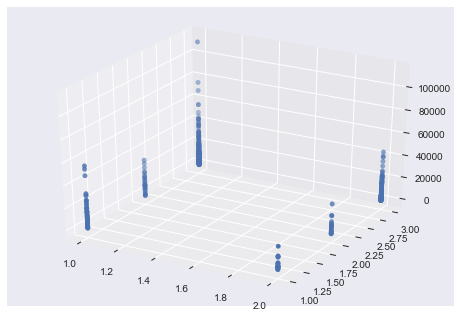

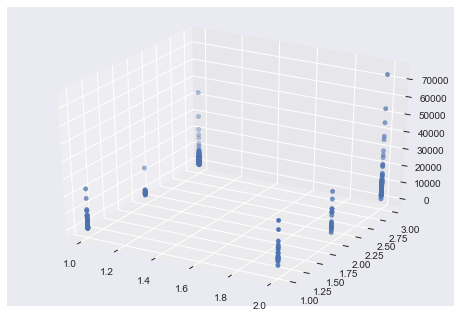

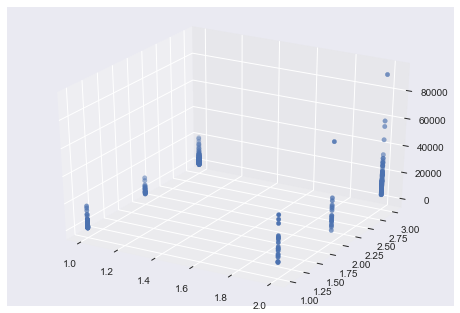

In [84]:
# # Use spiral dataset
# n = 1000
# X, y = get_spiral_data(n)
# print(X.shape, y.shape)

# User wholesale dataset
df = pd.read_csv("data/wholesale.csv")
X = df[['Channel', 'Region']].values.astype(np.float32)
y = df[['Fresh', 'Milk', 'Grocery']].values.astype(np.float32)

# Plot 2D or 3D graph according to X dimension
plot_data(X, y)

# Convert to TF dataset
dataset = tf.data.Dataset \
    .from_tensor_slices((X,y)) \
    .shuffle(n).batch(n)

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
baselayer (Dense)               (None, 50)           150         input_10[0][0]                   
__________________________________________________________________________________________________
dense_var_layer (Dense)         (None, 12)           612         baselayer[0][0]                  
__________________________________________________________________________________________________
pi_layer (Dense)                (None, 4)            204         baselayer[0][0]                  
____________________________________________________________________________________________

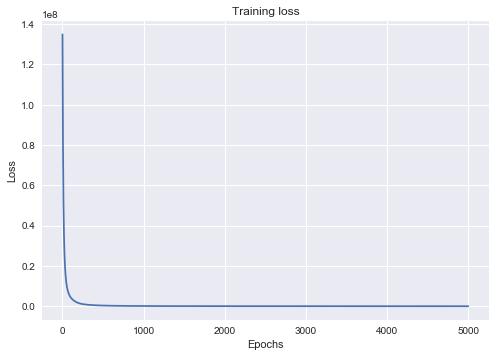

In [62]:
# Build GMM
gmm = GMM(x=2, l=3, k=4, verbose=True)
gmm.fit(dataset, epochs=5000, plot=True)
y_hat = gmm.predict(X)

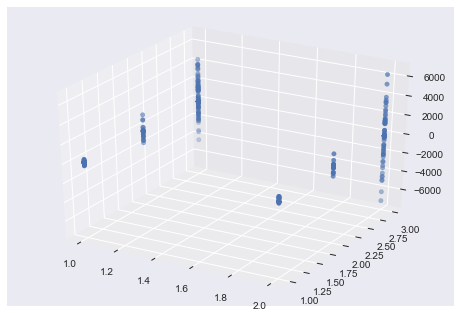

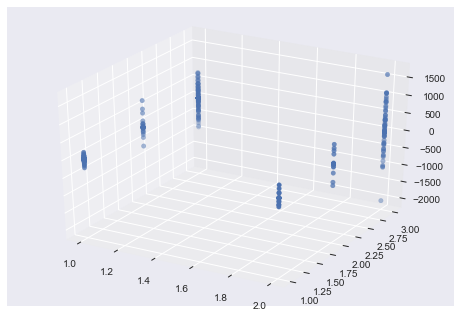

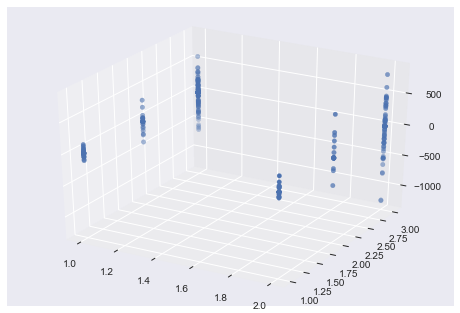

In [87]:
plot_data(X, y_hat)